# Decision tree on bert embeddings

In [58]:
import utilities
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import spacy
import re
import sklearn
import random
import textdistance
import umap

from spacy.vocab               import Vocab
from spacy.language            import Language
from spacy.tokens              import Token
from spacymoji                 import Emoji
from sklearn.tree              import DecisionTreeClassifier
from sklearn.model_selection   import train_test_split
from sklearn                   import metrics
from transformers              import BertTokenizer, BertModel
from sentence_transformers     import SentenceTransformer
from sklearn.metrics           import roc_curve

In [6]:
chanel_junk_valid_new = pd.read_excel('C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel_junk_valid_new.xlsx')

## Bert

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\a.tekiouk\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


## Sentence transformers 

Example

In [2]:
model_example = SentenceTransformer('all-MiniLM-L6-v2')

In [3]:
#Our sentences we like to encode
sentences_test = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.',
    'The quick brown fox jumps over the lazy dog.']

In [4]:
#Sentences are encoded by calling model.encode()
embeddings_test = model_example.encode(sentences_test)

In [8]:
#Print the embeddings
for sentence, embedding in zip(sentences_test, embeddings_test):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: This framework generates embeddings for each input sentence
Embedding: [-1.37173552e-02 -4.28515412e-02 -1.56286098e-02  1.40537675e-02
  3.95537615e-02  1.21796317e-01  2.94333659e-02 -3.17524336e-02
  3.54959927e-02 -7.93139786e-02  1.75878350e-02 -4.04370092e-02
  4.97259349e-02  2.54912134e-02 -7.18700662e-02  8.14968720e-02
  1.47072482e-03  4.79627065e-02 -4.50336114e-02 -9.92174670e-02
 -2.81769820e-02  6.45046234e-02  4.44670580e-02 -4.76217046e-02
 -3.52952480e-02  4.38671671e-02 -5.28566055e-02  4.33045556e-04
  1.01921499e-01  1.64072420e-02  3.26996632e-02 -3.45986634e-02
  1.21339280e-02  7.94871151e-02  4.58342070e-03  1.57778412e-02
 -9.68210399e-03  2.87625976e-02 -5.05806208e-02 -1.55793503e-02
 -2.87907012e-02 -9.62282438e-03  3.15556787e-02  2.27348972e-02
  8.71449485e-02 -3.85027118e-02 -8.84718373e-02 -8.75501521e-03
 -2.12343540e-02  2.08923593e-02 -9.02077407e-02 -5.25732078e-02
 -1.05638644e-02  2.88310759e-02 -1.61455162e-02  6.17835438e-03
 -1.23234

### Sentence transformer + UMAP on chanel Dataset

In [31]:
y = chanel_junk_valid_new['is_junk']

In [32]:
model1 = SentenceTransformer('all-MiniLM-L6-v2')
embeddings1 = model1.encode(chanel_junk_valid_new['text'])
X_1 = embeddings1
X_1.shape
# 390 rows, 384 cols

(390, 384)

In [65]:
manifold1 = umap.UMAP(n_components = 5).fit(X_1, y)
X_1_reduced = manifold1.transform(X_1)

In [66]:
X_1_reduced.shape

(390, 5)

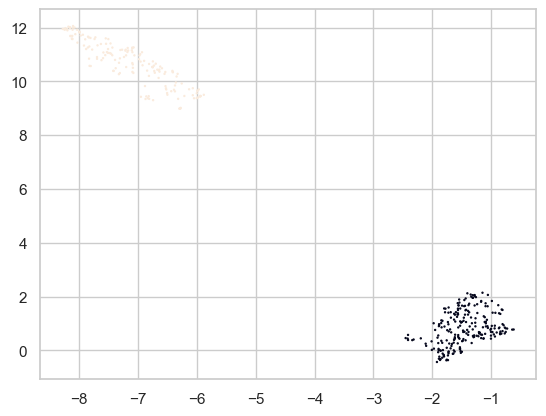

In [67]:
plt.scatter(X_1_reduced[:, 0], X_1_reduced[:, 1], c=y, s=0.5);

Decision tree

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_1_reduced,y, test_size=0.30, random_state=42)

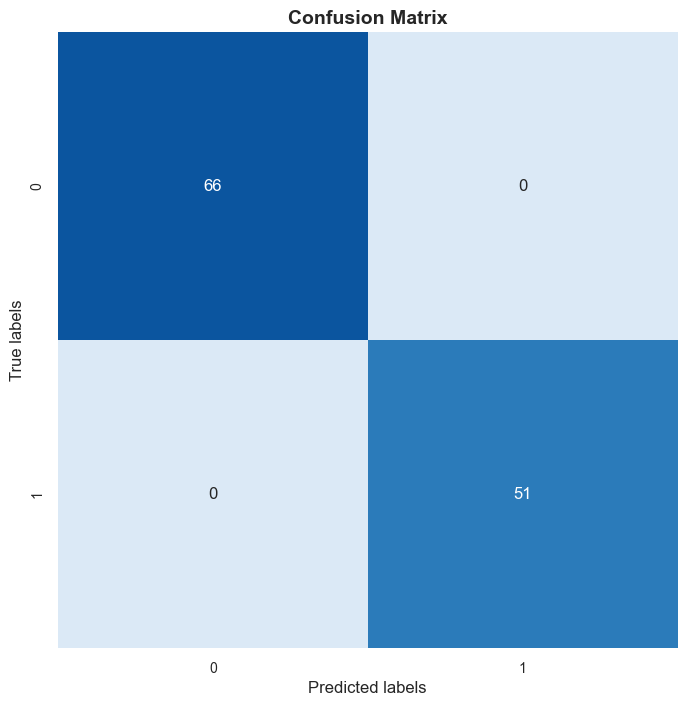

AUC : 1.0
Accuracy score : 1.0


In [72]:
tree = DecisionTreeClassifier(random_state = 42,criterion = 'entropy', max_depth = 5, ccp_alpha =  0, min_samples_leaf = 5, max_features = 5, min_samples_split = 13)
tree.fit(X_train,y_train)
y_pred = tree.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")

[Text(0.5, 0.75, '[-1.2794524  1.6707053 -0.8925673 11.212489   8.793573 ] <= 6.334\nentropy = 0.977\nsamples = 273\nvalue = [161, 112]\nclass = 1'),
 Text(0.25, 0.25, 'entropy = 0.0\nsamples = 112\nvalue = [0, 112]\nclass = 0'),
 Text(0.75, 0.25, 'entropy = 0.0\nsamples = 161\nvalue = [161, 0]\nclass = 1')]

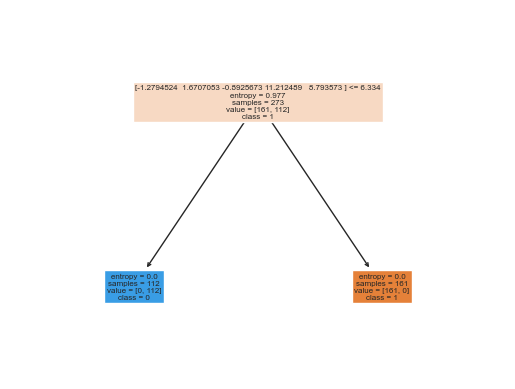

In [73]:
sklearn.tree.plot_tree(tree,feature_names = X_train, class_names = ['1','0'], filled = True)

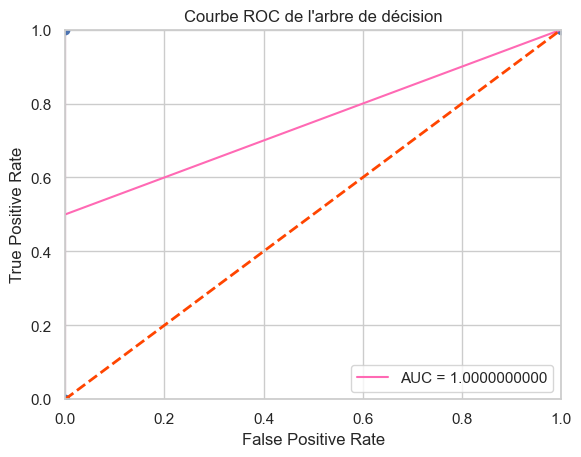

In [71]:
# Calcul des valeurs TPR et FPR
y_score = tree.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = metrics.auc(fpr, tpr)

# Tracé de la courbe ROC avec seaborn
sns.set(style='whitegrid', font_scale=1)
sns.lineplot(x=fpr, y=tpr, color='hotpink', label=f'AUC = {roc_auc:.10f}')
plt.plot([0, 1], [0, 1], color='orangered', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC de l\'arbre de décision')
plt.legend(loc='lower right')
plt.scatter(fpr,tpr)
plt.show()